In [1]:
import ticktack
from ticktack import fitting

from time import process_time
from plotnine import *
from pandas import DataFrame

from jax.numpy import arange, array

from ticktack.ode import odeint as BS3
from jax.experimental.ode import odeint as DP5

In [2]:
MODELS = { # This dictionary contains the units for the fluxes and production function
    "Guttler14": {  # Units of the Guttler 2014 paper
        "production_rate_units": "atoms/cm^2/s",    # Units of the production rate 
        "flow_rate_units": "Gt/yr"                  # Units of the fluxes
    },
    "Brehm21": {    # Units used by the Brehm, et. al. paper
        "production_rate_units": "kg/yr",    # Units of the production rate
        "flow_rate_units": "Gt/yr"           # Units of the fluxes
    },
    "Buntgen18": {  # The units used by the Buntgen 2018 paper
        "production_rate_units": "atoms/cm^2/s",    # Units of the production function
        "flow_rate_units": "Gt/yr"                  # Units of the fluxes 
    },
    "Miyake17": {   # The units used by the Miyake 2017 et. al. paper
        "production_rate_units": "atoms/cm^2/s",    # Units of the production function 
        "flow_rate_units": "1/yr"                   # Units of the fluxes.
    }
}

In [3]:
model_fitting_objects = {   # A dictionary to store each of the models
    "Guttler14": None, "Brehm21": None,
    "Buntgen18": None, "Miyake17": None
}

In [4]:
SOLVERS = { # A dictionary that links the string representation of a solver to the solver callable 
    "BS3": BS3, # The 3-4 runge-kutta solver from easy-neural-ode.py
    "DP5": DP5  # The standard 4-5 runge-kutta from JAX
}

In [5]:
for model in MODELS:
    # Loading each carbon box model with the correct units 
    carbon_box_model = ticktack.load_presaved_model(model, 
        production_rate_units=MODELS[model]["production_rate_units"], 
        flow_rate_units=MODELS[model]["flow_rate_units"])

    fitting_object = fitting.SingleFitter(carbon_box_model, cbm_model=model)
    fitting_object.load_data("miyake12.csv")
    fitting_object.compile_production_model("simple_sinusoid")

    model_fitting_objects[model] = fitting_object

INFO[2022-01-26 14:18:07,341]: Unable to initialize backend 'tpu_driver': Not found: Unable to find driver in registry given worker: 
INFO[2022-01-26 14:18:07,341]: Unable to initialize backend 'gpu': Not found: Could not find registered platform with name: "cuda". Available platform names are: Interpreter Host
INFO[2022-01-26 14:18:07,343]: Unable to initialize backend 'tpu': Invalid argument: TpuPlatform is not available.
WARNING[2022-01-26 14:18:07,344]: No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [6]:
tolerance_frame = { # A DataFrame seed 
    "solver": [],   # The species of solver that is to be used
    "type": [],     # The model that is used 
    "tolerance": [],# The value of atol and rtol
    "year": [],     # The year of the long form sim
    "dc14": []      # the dc14 corresponding to the long form year 
}

time_frame = {      # A DataFrame seed
    "solver": [],   # The species of solver
    "type": [],     # The model
    "time": [],     # The run time
    "tolerance": [] # The tolerance always the same for atol and rtol 
}

tolerance_range = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]  # Range of tolerances to be tested

In [7]:
for solver in SOLVERS:
    for model in model_fitting_objects:
        for tol in tolerance_range:
            # Choosing the correct solver and assigning the tolerances 
            model_fitting_objects[model].set_solver(
                SOLVERS[solver], rtol=tol, atol=tol)
            
            # Timing the excecution
            timer = process_time()
            fit_array = model_fitting_objects[model].dc14_fine(
                params=(774.86, 0.25, 0.8, 6.44))
            timer = process_time() - timer

            fit_shape = len(fit_array)  # Just for the repetition of values 

            # Adding to the tolerance DataFrame seed
            tolerance_frame["solver"].extend([solver for _ in range(fit_shape)])
            tolerance_frame["type"].extend([model for _ in range(fit_shape)])
            tolerance_frame["tolerance"].extend([tol for _ in range(fit_shape)])
            tolerance_frame["year"].extend([year for year in range(fit_shape)])
            tolerance_frame["dc14"].extend(fit_array)
            
            # Adding a row to the time DataFrame seed
            time_frame["solver"].append(solver)
            time_frame["type"].append(model)
            time_frame["time"].append(timer)
            time_frame["tolerance"].append(tol)

/home/jordan/anaconda3/envs/kitkat/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


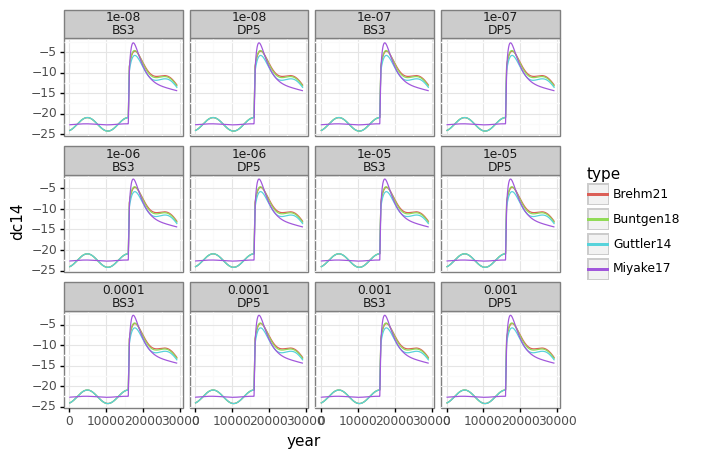

<ggplot: (8765705803180)>

In [8]:
tolerance_frame = DataFrame(tolerance_frame)
(ggplot(tolerance_frame, aes(x="year", y="dc14", color="type"))
    + geom_line()
    + theme_bw()
    + facet_wrap(facets="~ tolerance + solver"))

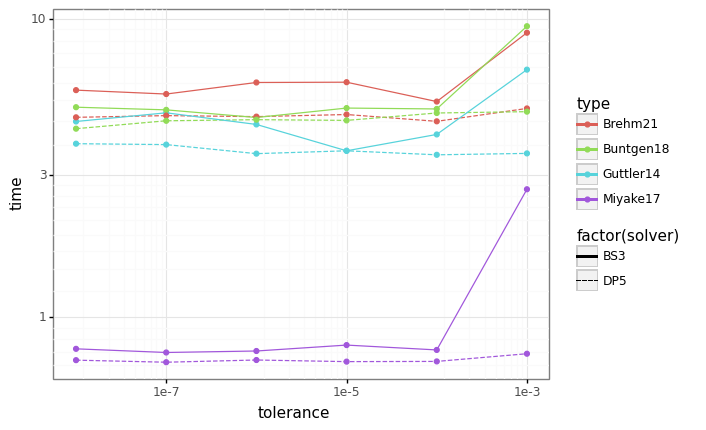

<ggplot: (8765562011715)>

In [9]:
time_frame = DataFrame(time_frame)
(ggplot(time_frame, aes(x="tolerance", y="time", color="type", linetype="factor(solver)"))
    + geom_line()
    + geom_point() 
    + scale_x_log10()
    + scale_y_log10()
    + theme_bw())

This compares the final results

In [10]:
SOLVER_TOLS = { 
    "BS3": 1e-8, 
    "DP5": 1e-10
}

In [11]:
module_times = {"solver": [], "time": [], "run": []}

In [12]:
for solver in SOLVER_TOLS:
    # Preparing the box model for Guttler14
    carbon_box_model = ticktack.load_presaved_model(
        "Guttler14", production_rate_units="atoms/cm^2/s")
    carbon_box_model.compile()

    # Getting the desired production function s
    production_function = fitting.SingleFitter(carbon_box_model, \
        "Guttler14").simple_sinusoid

    # Running the model to observe the `jit` behaviour 
    for run in range(10):
        timer = process_time()
        carbon_box_model.run(
            time_out=arange(0, 800), 
            oversample=108, 
            production=production_function,
            solver=SOLVERS[solver],
            args=array([774.86, 0.25, 0.8, 6.44]),
            steady_state_production=1.76,
            rtol=SOLVER_TOLS[solver],
            atol=SOLVER_TOLS[solver]
        )
        timer = process_time() - timer

        # Appending to the DataFrame seed
        module_times["solver"].append(solver)
        module_times["time"].append(timer)
        module_times["run"].append(run)

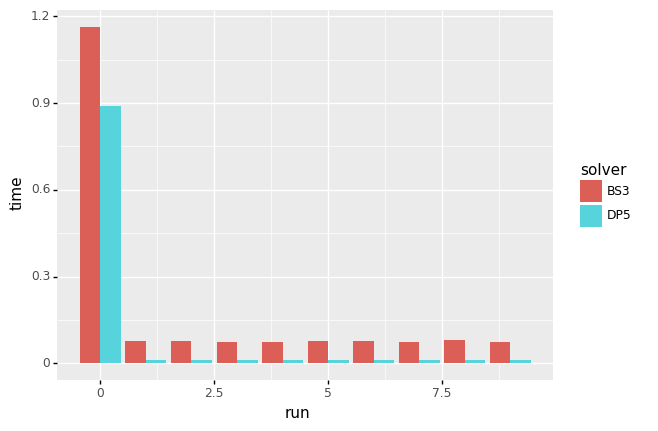

<ggplot: (8765781192593)>

In [13]:
module_times = DataFrame(module_times)
(ggplot(module_times, aes(x="run", y="time", fill="solver"))
    + geom_col(position="dodge"))